# Introdução

O nosso objetivo para escolher o dataset era avaliar as notas e desempenho dos alunos com base em variáveis sociais / de estudo, sem considerar questões socioeconômicas. Sobre aplicações sociais, pensamos em como seria importante acompanhar o aluno durante o tempo anterior à prova, fazendo questionários antes, ir trabalhando nos pontos fracos do aluno e melhorar o desempenho geral do ensino nas escolas municipais com base nas respostas dadas pelo aluno. Esse estudo promove a ideia de que o desempenho do aluno poderia ser "previsto", mesmo se o questionário fosse respondido meses antes da prova em si, o que trás um alarme para como a qualidade de ensino deve ser melhorada, mas o aluno também pode ter melhores resultados, caso tenha um acompanhamento considerando essas variáveis.

# Descrição do Dataset

O Sistema de Avaliação da Educação Básica (Saeb) é um conjunto de avaliações externas em larga escala que permite ao Inep realizar um diagnóstico da educação básica brasileira e de fatores que podem interferir no desempenho do estudante. Desde 1995, a avaliação bienal busca fornecer um panorama da Educação Básica e sofreu algumas mudanças metodológicas para aprimoramento. Juntamente com outros indicadores, as notas do SAEB estruturam a nota do Índice de Desenvolvimento da Educação Básica (Ideb). Por meio de testes e questionários, aplicados a cada dois anos na rede pública e em uma amostra da rede privada, o Saeb reflete os níveis de aprendizagem demonstrados pelos estudantes avaliados, explicando esses resultados a partir de uma série de informações contextuais. Avalia as séries: 5º ano, 9º ano e 3º ano do EM. Em 2019, tem o 2º ano do E.F.

# Tratamento / Análise de Dados

Após a escolha do Dataset, disponível em [Base dos Dados - SAEB](https://basedosdados.org/dataset/e083c9a2-1cee-4342-bedc-535cbad6f3cd?table=d429a79a-eca1-461c-9c1f-ce65d61048a1), precisamos fazer o tratamento dos dados, tratamento das colunas, análise das correlações / feature engineering e análise dos dados, tudo para que tivéssemos os dados da melhor forma possível. Os notebooks estão separados em ordem, visando a [Reproducible Research](https://book.the-turing-way.org/reproducible-research/reproducible-research). Considerados como códigos-fonte a parte do projeto principal, eles estão separados na pasta `treatment_analysis/` da forma:

1. initial-treatment.ipynb: Contém o tratamento inicial, a lógica para juntar os dados de 2007 até 2017 (considerando que as provas são realizadas a cada 2 anos) e tratamentos básicos como preencher idades faltantes e remover questionários nao preenchidos;
2. columns-treatment.ipynb: Contém a transformação das colunas do dataset (com base no dicionário das perguntas) pra valores discretos, de forma ordinal. Também são retiradas colunas não consideradas para o estudo e remoção de outliers com base na proficiencia / erro_padrao;
3. correlation_featureengineering.ipynb: Contém a análise das correlações entre as variáveis / features a partir de heatmaps e remoção de colunas com baixa ou nenhuma correlação com o desempenho do aluno. O dataset utilizado para treinar os modelos também é salvo desse notebook;
4. data-analysis.ipynb: Contém a análise dos dados, com foco na distribuição das classes com base na proficiência e erro padrão do aluno e a aplicação de PCA para relacionar as variáveis entre si.


# 1. Tratamento de Dados Básico

In [268]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

from IPython.display import clear_output

clear_output()

cwd = os.getcwd()

ROOT = os.path.join(cwd)
DATA_FOLDER = os.path.join(ROOT, 'data/')

In [269]:
colab = False
if colab:
    df = pd.read_pickle('saeb_pb_2017-2007_fe.pkl')
else:
    df = pd.read_pickle(os.path.join(DATA_FOLDER, 'saeb_pb_2017-2007_fe.pkl'))
df = df.dropna()
df.head()

,id_aluno,disciplina,proficiencia,erro_padrao,desempenho_aluno,desempenho_aluno_cat,faz_licao_casa_2.0,reprovacao_0.0,reprovacao_1.0,pai_sabe_ler_escrever_1.0,leitura_revista_comportamento_0.0,leitura_jornais_0.0,escolaridade_pai_4.0,mae_sabe_ler_escrever_1.0,leitura_internet_2.0,tempo_lazer_1.0,escolaridade_mae_4.0,gosta_estudar_disciplina_0.0,gosta_estudar_disciplina_1.0
8086,23061434,LP,0.665701,0.312872,Proficiente,2,True,True,False,False,True,True,False,True,True,True,False,False,True
10602,23065563,LP,-1.353424,0.484866,Insuficiente,0,True,False,True,True,False,False,False,False,True,True,False,False,True
13975,23065563,MT,-1.652930,0.564617,Insuficiente,0,True,False,True,True,False,False,False,False,True,True,False,False,True
17847,23065552,MT,-1.099605,0.467812,Insuficiente,0,True,True,False,False,False,False,False,True,False,False,False,False,True
20664,23095249,MT,-1.262341,0.512487,Insuficiente,0,False,False,True,True,False,False,False,True,True,False,False,True,False


In [270]:
# colunas a serem excluidas (não serão consideradas como features em X)
exclude = ['ano', 'sigla_uf', 'id_aluno', 'situacao_censo', 'disciplina', 'proficiencia', 'erro_padrao', 'proficiencia_saeb',
       'erro_padrao_saeb', 'sexo', 'raca_cor','ano_nascimento', 'rede', 'id_escola', 'serie', 'turno', 'escola_publica', 'desempenho_aluno']

exclude = [col for col in df.columns if col in exclude]

In [271]:
# print unique values for each column

for col in df.columns:
    if col not in exclude:
        print(col, df[col].unique())

desempenho_aluno_cat [2 0 3 1]
faz_licao_casa_2.0 [ True False]
reprovacao_0.0 [ True False]
reprovacao_1.0 [False  True]
pai_sabe_ler_escrever_1.0 [False  True]
leitura_revista_comportamento_0.0 [ True False]
leitura_jornais_0.0 [ True False]
escolaridade_pai_4.0 [False  True]
mae_sabe_ler_escrever_1.0 [ True False]
leitura_internet_2.0 [ True False]
tempo_lazer_1.0 [ True False]
escolaridade_mae_4.0 [False  True]
gosta_estudar_disciplina_0.0 [False  True]
gosta_estudar_disciplina_1.0 [ True False]


Tratar os dados e construir a matriz $X$ e o vetor $y$ de entrada para o classificador;

**Para o treinamento, utilizaremos Under Sampling com a justificativa do alto desbalanceamento das classes nos dados**

In [272]:
df['desempenho_aluno'].value_counts()

desempenho_aluno
Básico          124830
Insuficiente     78056
Proficiente      26662
Avançado          3334
Name: count, dtype: int64

In [273]:
X = df.drop(columns=exclude + ['desempenho_aluno_cat'])
y = df['desempenho_aluno_cat']

X = X.astype('float32')
y = y.astype('float32')

rus = RandomUnderSampler(random_state=0)
X, y = rus.fit_resample(X, y)

y = to_categorical(y)

In [274]:
np.unique(y, axis=0, return_counts=True)

(array([[0., 0., 0., 1.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.]]),
 array([3334, 3334, 3334, 3334]))

Identificar o número de exemplos ($N$) e número de features;

In [275]:
N = len(X) # número de exemplos
n_features = X.shape[1] # número de features

print('Número de exemplos:', N)
print('Número de features:', n_features)

Número de exemplos: 13336
Número de features: 13


Separar os dados (𝑋,𝑦) entre treinamento e teste, justificando a quantidade de exemplos de cada grupo de dados. Não mexer no teste até a fase final de computação das métricas de aprendizado;

In [276]:
# separando em 20% para teste e 80% para treino
# por ser o valor mais comum
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# agora, separando os dados de treino em 20% para validação
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print('Número de exemplos de treino:', len(X_train))
print('Número de exemplos de validação:', len(X_val))
print('Número de exemplos de teste:', len(X_test))

Número de exemplos de treino: 8534
Número de exemplos de validação: 2134
Número de exemplos de teste: 2668


Aplicar normalização ou padronização dos dados, justificando a escolha do método.

In [277]:
# não precisaremos aplicar normalização ou padronização nos dados,
# pois são de origem binária para todas as colunas, isto é, vão de 0 a 1.
# esse tratamento foi feito na etapa de feature engineering

# 2. Implementação do modelo baseado em Rede Neural

Definir a arquitetura da rede neural (número de camadas e o número de neurônios por camada) a partir do número de exemplos disponíveis no dataset e da “Regra de Ouro”, que é consequência da Teoria da Generalização do Aprendizado. Use o cálculo da dimensão VC para justificar a escolha da arquitetura mencionada. Obs: Não esqueça da existência do bias em cada neurônio e use o Teorema da Aproximação Universal; 

In [278]:
def num_neurons(n_examples, n_features):
    return int((n_examples - 10) / (10 * (n_features + 2) ))

In [279]:
# podemos usar 2 camadas e é o suficiente
# número de neurônios por camada
print(X_train.shape)

print('De acordo com a regra de ouro da dimensão VC, \no número de neurônios por camada oculta \ndeve ser menor ou igual que')
print(num_neurons(len(X_train), n_features))

(8534, 13)
De acordo com a regra de ouro da dimensão VC, 
o número de neurônios por camada oculta 
deve ser menor ou igual que
56


Vamos inicializar um modelo sequencial com as escolhas de hiperparâmetros:
- funções de ativação 'ReLU': É uma função com custo computacional mais baixo do que 'tanh', o que acaba deixando o treinamento mais rápido.
- regularizador 'l2': Devido ao baixo número de exemplos no dataset após o Under Sampling, existe uma alta chance de overfitting pelo número de features (13), então além de ajudar a prevenir overfitting, a regularização também adicionará penalidade aos pesos, reduzindo a complexidade do modelo.
- Dropout: Pela alta chance de overfitting dado o número de neurônios, é adicionado Dropout para reduzir a capacidade / complexidade do modelo também, ajudando a generalizar.  
- EarlyStopping: Para que não haja "Boca de Jacaré", é adicionado uma cláusula de Early Stopping para impedir que o modelo continue o treinamento caso seja detectada uma piora na acurácia de validação.
- Função de ativação 'softmax': É a função de ativação utilizada para classificação multiclasse. Retorna probabilidades para cada classe.
- Função de perda 'categorical_crossentropy': É a função de perda utilizada para classificação multiclasse. Calcula o erro com base nas probabilidades resultantes de cada classe para cada exemplo predito.

In [280]:
model = Sequential()

model.add(Dense(4, input_dim=X_train.shape[1], activation='relu', kernel_regularizer='l2'))
model.add(Dropout(0.1))
model.add(Dense(8, activation='relu', kernel_initializer='normal'))
model.add(Dropout(0.2))
model.add(Dense(4, kernel_initializer='normal', activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# Compilar o modelo
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

/home/erlo/.local/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_41 (Dense)                │ (None, 4)              │            56 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 8)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 4)              │            36 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132 (528.00 B)

 Trainable params: 132 (528.00 B)

 Non-trainable params: 0 (0.00 B)

In [281]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=48, callbacks=[es])

Epoch 1/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2639 - loss: 1.4250 - val_accuracy: 0.2826 - val_loss: 1.3994
Epoch 2/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step - accuracy: 0.3402 - loss: 1.3825 - val_accuracy: 0.4007 - val_loss: 1.3102
Epoch 3/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step - accuracy: 0.3876 - loss: 1.3030 - val_accuracy: 0.4016 - val_loss: 1.2738
Epoch 4/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step - accuracy: 0.3895 - loss: 1.2865 - val_accuracy: 0.4049 - val_loss: 1.2636
Epoch 5/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step - accuracy: 0.3994 - loss: 1.2793 - val_accuracy: 0.4105 - val_loss: 1.2543
Epoch 6/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step - accuracy: 0.3930 - loss: 1.2706 - val_accuracy: 0.4110 - val_loss: 1.2498
Epoch 7/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step - accuracy: 0.4049 - loss: 1.2631 - val_accuracy: 0.4138 - val_loss: 1.2499
Epoch 8/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - accuracy: 0.3897 - loss: 1.2

Computar o $𝐸_{in}$ e  $𝐸_{out}$ para analisar a existência de overfitting;

In [282]:
Ein = history.history['loss'][-1]
Eout = history.history['val_loss'][-1]

print(f'\n--> E_in: {Ein:.4f}')
print(f'--> E_out: {Eout:.4f}')

print('--> E_in - E_out:', Ein - Eout)
# como podemos ver não há overfitting devido a pequena diferença entre E_in e E_out


--> E_in: 1.2546
--> E_out: 1.2361
--> E_in - E_out: 0.018535733222961426


- Ocorreu overfitting? Se sim, isso ocorreu a partir de que época? Ilustrar sua resposta com um gráfico;

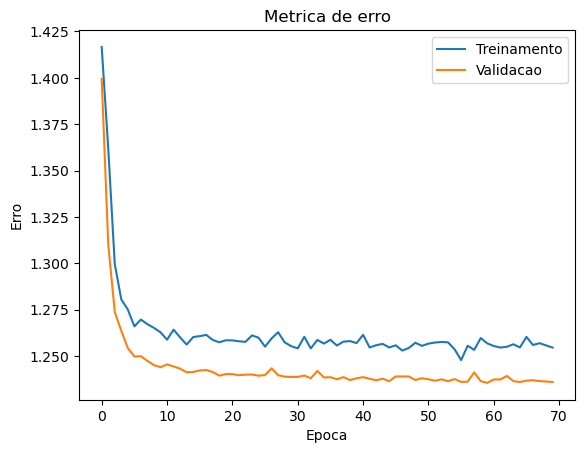

267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 605us/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/step

--> Acuracia (treino): 0.4122
--> Acuracia (validacao): 0.4166
--> acc_train - acc_val = -0.0044
--> E_val - E_in = -0.0185


In [283]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Metrica de erro')
plt.ylabel('Erro')
plt.xlabel('Epoca')
plt.legend(['Treinamento', 'Validacao'])
plt.show()

pred_train = model.predict(X_train)
pred_val = model.predict(X_val)

acc_train = accuracy_score(np.argmax(y_train, axis=1), np.argmax(pred_train, axis=1))
acc_val = accuracy_score(np.argmax(y_val, axis=1), np.argmax(pred_val, axis=1))

print(f'\n--> Acuracia (treino): {acc_train:.4f}')
print(f'--> Acuracia (validacao): {acc_val:.4f}')
print(f"--> acc_train - acc_val = {acc_train - acc_val:.4f}")
print(f"--> E_val - E_in = {(history.history['val_loss'][-1] - history.history['loss'][-1]):.4f}")

Não houve overfitting. Como podemos ver não há "Boca de Jacaré".

- Justificar as escolhas para os parâmetros batch size e o número de épocas;

**Número de épocas:** Não houve necessidade de determinar um valor fora do padrão (50 ou 100) já que foi adicionado Early Stopping, que iria parar o treinamento caso houvesse uma piora.  

**Batch size:** Não houve uma heurística específica, foi escolhido um valor visando menos custo computacional.

In [285]:
pass

- Computar  as  métricas  de  qualidade  da  melhor  rede  construída (acurácia,  precisão, recall, f1 score)

In [284]:
# métricas de avaliação
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

print(classification_report(y_test, y_pred))

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
              precision    recall  f1-score   support

           0       0.43      0.63      0.51       673
           1       0.26      0.18      0.22       652
           2       0.33      0.12      0.18       706
           3       0.43      0.66      0.52       637

    accuracy                           0.39      2668
   macro avg       0.36      0.40      0.36      2668
weighted avg       0.36      0.39      0.35      2668



# 3. Construção do modelo de Árvore de Decisão

- Construir uma árvore de decisão com a instância de treino; 



- Plotar a árvore e computar $𝐸_{in}$ e  $𝐸_{out}$ para analisar a existência de overfitting; 

- Regularizar o valor de 𝛼 utilizando o algoritmo de Minimal Cost-Complexity já 
implementado na classe DecisionTreeClassifier, para encontrar a árvore que 
minimize a relação:  

$$𝑃𝑢𝑟𝑒𝑧𝑎(𝑇)+ 𝛼 ∙\#𝑓𝑜𝑙ℎ𝑎𝑠(𝑇).$$

Esse processo deve ser realizado com a técnica de cross validation, onde o tamanho do fold deve ser definido pela dimensão do conjunto de treino;

- Plotar  a  imagem  e  computar  as  métricas  de  qualidade  da  melhor  árvore 
construída. 

# 4. Construção do modelo SVM

- Construir um modelo de SVM, regularizando dos parâmetros 𝐶 e 𝛾 (gama) através 
de cross validation, onde o tamanho do fold deve ser definido pela dimensão do 
conjunto de treino; 

In [291]:
X = df.drop(columns=exclude + ['desempenho_aluno_cat'])
y = df['desempenho_aluno_cat']

X = X.astype(int)
y = y.astype(int)

In [292]:
rus = RandomUnderSampler(random_state=42)
X, y = rus.fit_resample(X, y)

In [293]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [295]:
param_grid = {'C': [1, 5, 10],
                'gamma': [0.005, 0.01, 0.05, 0.1]}
grid = GridSearchCV(estimator=SVC(kernel='rbf'), param_grid=param_grid, cv=5, verbose=3)

%time grid.fit(X_train, y_train)

print(grid.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END ..................C=1, gamma=0.005;, score=0.401 total time=   2.0s
[CV 2/5] END ..................C=1, gamma=0.005;, score=0.381 total time=   2.3s
[CV 3/5] END ..................C=1, gamma=0.005;, score=0.416 total time=   2.2s
[CV 4/5] END ..................C=1, gamma=0.005;, score=0.395 total time=   2.2s
[CV 5/5] END ..................C=1, gamma=0.005;, score=0.399 total time=   2.3s
[CV 1/5] END ...................C=1, gamma=0.01;, score=0.396 total time=   2.3s
[CV 2/5] END ...................C=1, gamma=0.01;, score=0.376 total time=   2.2s
[CV 3/5] END ...................C=1, gamma=0.01;, score=0.418 total time=   2.2s
[CV 4/5] END ...................C=1, gamma=0.01;, score=0.384 total time=   2.2s
[CV 5/5] END ...................C=1, gamma=0.01;, score=0.399 total time=   1.9s
[CV 1/5] END ...................C=1, gamma=0.05;, score=0.396 total time=   2.0s
[CV 2/5] END ...................C=1, gamma=0.05;

In [297]:
clf = SVC(kernel='rbf', gamma=0.1, C=1)
clf.fit(X_train, y_train)

SVC(C=1, gamma=0.1)

- Computar o valor de $𝐸_{in}$,  $𝐸_{out}$ e o valor de $𝐸_{out}$ esperado, baseado no número de vetores de suporte utilizados na solução, para analisar a existência de overfitting; 

In [298]:
print(X_train.shape)

# computando Ein, Eout e o valor de Eout esperado
y_pred_train = clf.predict(X_train)

Ein = 1 - accuracy_score(y_train, y_pred_train)
Eout = 1 - accuracy_score(y_test, y_pred)

print(f'Ein: {Ein:.2f}')
print(f'Eout: {Eout:.2f}')

print()
# calculando Eout esperado
n_support_vectors = len(clf.support_)
n_samples = len(X_train)

print(f'Número de vetores de suporte: {n_support_vectors}')

Eout_expected = Ein + (n_support_vectors / n_samples)

print(f'Eout esperado: {Eout_expected:.2f}')

(10668, 13)
Ein: 0.59
Eout: 0.61

Número de vetores de suporte: 9917
Eout esperado: 1.52


- Computar  as  métricas  de  qualidade  de  classificação  do  melhor  modelo 
encontrado

In [299]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.43      0.63      0.51       673
           1       0.26      0.18      0.22       652
           2       0.33      0.12      0.18       706
           3       0.43      0.66      0.52       637

    accuracy                           0.39      2668
   macro avg       0.36      0.40      0.36      2668
weighted avg       0.36      0.39      0.35      2668

